# Learning Jax

In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

## Random

In [2]:
key = random.PRNGKey(0)
x = random.normal(key, (5,))
print(x)

[ 0.18784384 -1.2833426  -0.2710917   1.2490594   0.24447003]


In [3]:
x = random.normal(key, (10, 15), dtype=jnp.float32)
y = random.normal(key, (15, 5),  dtype=jnp.float32)
z = jnp.dot(x, y)
print(z)

[[-0.03693258  2.0722866   1.0815089   6.9263883   3.0092132 ]
 [ 0.9707529  -6.4077487  -8.182107    0.8150119   4.252639  ]
 [-2.7588344   1.0454758   0.95263463  5.0854063   3.5394762 ]
 [-0.5709582   1.6280751   0.08682457 -1.3918499   6.1496844 ]
 [ 2.140759   -2.9827328  -5.349362    4.145323   -4.961085  ]
 [ 2.905119   -2.876446    1.6135756  -2.2219296   5.4326425 ]
 [ 6.063915   -6.4037433   0.41179213  5.587041    1.0331964 ]
 [ 2.0874434  -3.0014112   1.9685963   3.0231938  -3.959516  ]
 [-4.7406015   6.8884363   2.087616   -4.4552464   2.4031346 ]
 [-4.5939116   6.616922   -4.4128494   2.6713064  -6.8339257 ]]


## Just-in-time compiler (JIT)

In [4]:
def selu(x, alpha=1.67, lmbda=1.05):
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

s = selu(z)
s_jit = jit(selu)(z)
print(s)
print(s_jit)

[[-0.06357998  2.175901    1.1355842   7.2727075   3.1596737 ]
 [ 1.0192904  -1.7506088  -1.7530096   0.8557625   4.4652705 ]
 [-1.6423883   1.0977496   1.0002663   5.3396764   3.7164497 ]
 [-0.76280075  1.7094789   0.09116579 -1.3175535   6.4571686 ]
 [ 2.2477968  -1.6646776  -1.7451687   4.3525887  -1.7412161 ]
 [ 3.0503747  -1.6547172   1.6942543  -1.563421    5.704274  ]
 [ 6.3671103  -1.7505972   0.43238172  5.8663926   1.0848563 ]
 [ 2.1918154  -1.6663214   2.0670261   3.1743534  -1.7200565 ]
 [-1.7381859   7.2328577   2.1919966  -1.7331287   2.523291  ]
 [-1.7357663   6.9477677  -1.7322464   2.8048716  -1.7516121 ]]
[[-0.06357993  2.175901    1.1355842   7.2727075   3.1596737 ]
 [ 1.0192904  -1.7506088  -1.7530096   0.8557625   4.4652705 ]
 [-1.6423883   1.0977496   1.0002663   5.3396764   3.7164497 ]
 [-0.76280075  1.7094789   0.09116579 -1.3175535   6.4571686 ]
 [ 2.2477968  -1.6646776  -1.7451687   4.3525887  -1.7412161 ]
 [ 3.0503747  -1.6547172   1.6942543  -1.563421    5.7

## AutoGrad (grad)

In [5]:
def sum_logistic(x):
    return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

w = jnp.arange(5.)
v = grad(sum_logistic)(w)
print(v)

[0.25       0.19661197 0.10499357 0.04517666 0.01766271]


In [6]:
def first_finite_differences(f, x):
    eps = 1e-3
    return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps) 
                      for v in jnp.eye(len(x))])

print(first_finite_differences(sum_logistic, w))

[0.2501011  0.19669531 0.10490417 0.04529953 0.01764297]


In [7]:
from jax import jacfwd, jacrev 
# jax.vjp() -> reverse-mode vector jacobian products
# jax.jvp() -> forward-mode jacobian vector products
def hessian(f):
    return jit(jacfwd(jacrev(f)))

# print(hessian(sum_logistic)(z))

## Auto vectorize (vmap)

In [8]:
mat = random.normal(key, (5, 100))
batched_val = random.normal(key, (10, 100))

@jit
def apply_mat(v):
    return jnp.dot(mat, v)

@jit
def naively_batched_apply_mat(batched):
    return jnp.stack([apply_mat(v) for v in batched])

@jit
def batched_apply_mat(batched):
    return jnp.dot(batched, mat.T)

@jit
def vmap_batched_apply_mat(batched):
    return vmap(apply_mat)(batched)

print(naively_batched_apply_mat(batched_val))
print(batched_apply_mat(batched_val))
print(vmap_batched_apply_mat(batched_val)) # auto vectorize qith vmap

[[ -4.4559917   10.582633    -6.589631    -9.125396   -17.868021  ]
 [  8.666637   -19.117474   -23.670912    -5.716485    -4.8673058 ]
 [  4.833417    22.061989   -14.900349    -3.7299807  -15.746187  ]
 [-11.834408   -11.38388     -6.1396027    8.757585    -5.0406666 ]
 [ 16.806973    -2.1090512  -13.47407     -8.805514     5.3359785 ]
 [ -2.6243715    3.4985855    0.6773355    3.641262    -5.2552104 ]
 [ 14.8428135   17.364367   -14.062406     1.7086288    7.708923  ]
 [ 11.895282     3.9323182  -11.907891    -4.6174564   11.009735  ]
 [-13.121435   -17.983427     2.3465488    0.90398437  -7.4857697 ]
 [ 20.753305     2.4128156   -3.3254943   -9.7962265   -1.6442086 ]]
[[ -4.45599    10.582633   -6.589631   -9.125397  -17.868023 ]
 [  8.666637  -19.117474  -23.670906   -5.7164845  -4.867306 ]
 [  4.8334155  22.06199   -14.900349   -3.7299807 -15.746187 ]
 [-11.834404  -11.383881   -6.1396017   8.757582   -5.040668 ]
 [ 16.806973   -2.1090527 -13.47407    -8.805512    5.3359785]
 [ -

## From numpy to jax

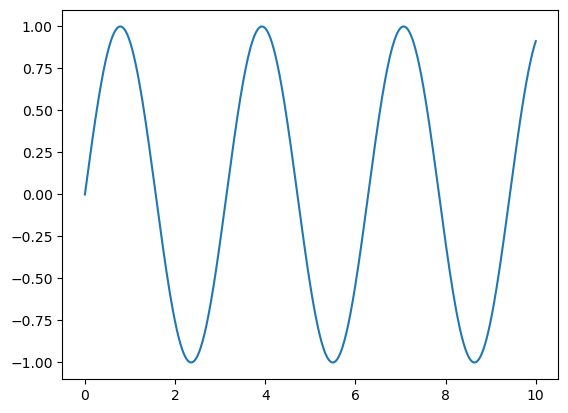

In [9]:
from matplotlib import pyplot as plt

x = jnp.linspace(0, 10, 1000)
y = 2 * jnp.sin(x) * jnp.cos(x)
plt.plot(x, y);

## Simple Neural network

In [10]:
def random_layer_params(m, n, key, scale=1e-2):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (m, n)), scale * random.normal(b_key, (1, n))

def init_network_params(sizes, key):
    keys = random.split(key, len(sizes) - 1)
    return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 512, 10]
step_size = 1e-2
num_epochs = 10
batch_size = 128
n_targets = 10
params = init_network_params(layer_sizes, random.PRNGKey(0))
print(f"Params: {[(m.shape, n.shape) for m, n in params]}")

Params: [((784, 512), (1, 512)), ((512, 512), (1, 512)), ((512, 10), (1, 10))]


In [108]:
a = jnp.array([1,2,3])
b = jnp.array([[1,2,3], [4,5,6]])
print(b.dot(a).shape, a.shape, b.shape)

(2,) (3,) (2, 3)


In [124]:
from jax.scipy.special import logsumexp

def relu(x):
    return jnp.maximum(0, x)

# def predict(params, images):
#     m = len(images)
#     inputs = images
#     for w, b in params[:-1]:
#         inputs = relu(inputs @ w + jnp.tile(b, (m, 1)))

#     w, b = params[-1]
#     outputs = inputs @ w + b
#     return outputs - logsumexp(outputs)

def predict(params, image):
    inputs = image
    for w, b in params[:-1]:
        inputs = relu(w.T.dot(inputs) + b.reshape(b.shape[1],))

    w, b = params[-1]
    outputs = w.T.dot(inputs) + b.reshape(b.shape[1],)
    return outputs - logsumexp(outputs)

batched_predict = vmap(predict, in_axes=(None, 0))
# batched_predict = predict

In [125]:
random_flattened_image = random.normal(random.PRNGKey(1), (10, 28 * 28))
preds = [jnp.argmax(p) for p in predict(params, jnp.array(random_flattened_image)[0])]
print(preds)

[Array(0, dtype=int32), Array(0, dtype=int32), Array(0, dtype=int32), Array(0, dtype=int32), Array(0, dtype=int32), Array(0, dtype=int32), Array(0, dtype=int32), Array(0, dtype=int32), Array(0, dtype=int32), Array(0, dtype=int32)]


In [126]:
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)
  
def accuracy(params, images, targets):
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

def loss(params, images, targets):
  preds = batched_predict(params, images)
  return -jnp.mean(preds * targets)

@jit
def update(params, x, y, step_size):
  grads = grad(loss)(params, x, y)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

In [129]:
import time

def get_train_batches():
  ds = tfds.load(name='mnist', split='train', as_supervised=True, data_dir=data_dir)
  ds = ds.batch(batch_size).prefetch(1)
  return tfds.as_numpy(ds)

def train(params, images, labels, test_images, test_labels, 
          learning_rate=1e-2, num_epochs=10, batch_size=128):
    inputs = images
    history = []
    for epoch in range(num_epochs):
        start_time = time.time()
        for x, y in get_train_batches():
            x = jnp.reshape(x, (len(x), num_pixels))
            y = one_hot(y, num_labels)
            params = update(params, x, y, learning_rate)
        epoch_time = time.time() - start_time
        train_acc = accuracy(params, images, labels)
        val_acc = accuracy(params, test_images, test_labels)
        print("Epoch {}, train_acc: {:0.4f}, val_acc: {:0.4f} in {:0.2f} sec".format(epoch, train_acc, val_acc, epoch_time))
        history.append({ "epoch_time": epoch_time, "train_acc": train_acc, "val_acc": val_acc })
        
    return params, history

## Dataset

In [127]:
import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

data_dir = '/tmp/tfds'

# Fetch full datasets for evaluation
# tfds.load returns tf.Tensors (or tf.data.Datasets if batch_size != -1)
# You can convert them to NumPy arrays (or iterables of NumPy arrays) with tfds.dataset_as_numpy
mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
num_labels = info.features['label'].num_classes
h, w, c = info.features['image'].shape
num_pixels = h * w * c

# Full train set
train_images, train_labels = train_data['image'], train_data['label']
train_images = jnp.reshape(train_images, (len(train_images), num_pixels))
train_labels = one_hot(train_labels, num_labels)

# Full test set
test_images, test_labels = test_data['image'], test_data['label']
test_images = jnp.reshape(test_images, (len(test_images), num_pixels))
test_labels = one_hot(test_labels, num_labels)


In [128]:
print('Train:', train_images.shape, train_labels.shape)
print('Test:', test_images.shape, test_labels.shape)

Train: (60000, 784) (60000, 10)
Test: (10000, 784) (10000, 10)


In [91]:
model = train(params, train_images, train_labels, test_images, test_labels)

Epoch 0, train_acc: 0.9239, val_acc: 0.9249 in 0.95 sec
Epoch 1, train_acc: 0.9414, val_acc: 0.9431 in 0.76 sec
Epoch 2, train_acc: 0.9506, val_acc: 0.9503 in 0.76 sec
Epoch 3, train_acc: 0.9564, val_acc: 0.9547 in 0.76 sec
Epoch 4, train_acc: 0.9611, val_acc: 0.9597 in 0.76 sec
Epoch 5, train_acc: 0.9647, val_acc: 0.9627 in 0.77 sec
Epoch 6, train_acc: 0.9681, val_acc: 0.9648 in 0.76 sec
Epoch 7, train_acc: 0.9707, val_acc: 0.9672 in 0.76 sec
Epoch 8, train_acc: 0.9730, val_acc: 0.9684 in 0.76 sec
Epoch 9, train_acc: 0.9748, val_acc: 0.9696 in 0.76 sec


In [130]:
model = train(params, train_images, train_labels, test_images, test_labels)

Epoch 0, train_acc: 0.9225, val_acc: 0.9251 in 0.97 sec
Epoch 1, train_acc: 0.9406, val_acc: 0.9410 in 0.76 sec
Epoch 2, train_acc: 0.9515, val_acc: 0.9493 in 0.75 sec
Epoch 3, train_acc: 0.9592, val_acc: 0.9551 in 0.75 sec
Epoch 4, train_acc: 0.9645, val_acc: 0.9591 in 0.77 sec
Epoch 5, train_acc: 0.9688, val_acc: 0.9619 in 0.76 sec
Epoch 6, train_acc: 0.9721, val_acc: 0.9639 in 0.75 sec
Epoch 7, train_acc: 0.9747, val_acc: 0.9658 in 0.75 sec
Epoch 8, train_acc: 0.9767, val_acc: 0.9677 in 0.75 sec
Epoch 9, train_acc: 0.9790, val_acc: 0.9692 in 0.76 sec


## Flax

In [133]:
from typing import Sequence

import flax.linen as nn

class MLP(nn.Module):
  layer_sizes: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for size in self.layer_sizes[:-1]:
      x = nn.relu(nn.Dense(size)(x))
    x = nn.Dense(self.layer_sizes[-1])(x)
    x = nn.log_softmax(x)
    return x

layer_sizes = [784, 512, 512, 10]
model = MLP(layer_sizes)
print(model.tabulate(jax.random.key(0), jnp.ones((1, 784)), 
                     compute_flops=True, compute_vjp_flops=True))


                                  MLP Summary                                   
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs     ┃ outputs    ┃ flops   ┃ vjp_flops ┃ params    ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━┩
│         │ MLP    │ float32[1… │ float32[1… │ 2570320 │ 8992434   │           │
├─────────┼────────┼────────────┼────────────┼─────────┼───────────┼───────────┤
│ Dense_0 │ Dense  │ float32[1… │ float32[1… │ 1230096 │ 4304160   │ bias:     │
│         │        │            │            │         │           │ float32[… │
│         │        │            │            │         │           │ kernel:   │
│         │        │            │            │         │           │ float32[… │
│         │        │            │            │         │           │           │
│         │        │            │            │         │           │ 615,440   │
│         │        │       

In [136]:
from clu import metrics
from flax.training import train_state
from flax import struct
import optax

@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(module, rng, learning_rate, momentum):
    params = module.init(rng, jnp.ones([1, 784]))['params']
    tx = optax.sgd(learning_rate, momentum)
    return TrainState.create(
        apply_fn=module.apply, params=params, tx=tx, 
        metrics=Metrics.empty())

@jit
def train_step(state, batch):
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, batch['image'])
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=batch['label']).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

@jit
def compute_metrics(*, state, batch):
    logits = state.apply_fn({'params': state.params}, batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label'], loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

ModuleNotFoundError: No module named 'clu'

In [138]:
num_epochs = 10
batch_size = 32

def get_datasets(num_epochs, batch_size):
  """Load MNIST train and test datasets into memory."""
  train_ds = tfds.load('mnist', split='train')
  test_ds = tfds.load('mnist', split='test')

  train_ds = train_ds.map(lambda sample: {'image': tf.cast(sample['image'],
                                                           tf.float32) / 255.,
                                          'label': sample['label']}) # normalize train set
  test_ds = test_ds.map(lambda sample: {'image': tf.cast(sample['image'],
                                                         tf.float32) / 255.,
                                        'label': sample['label']}) # normalize test set

  train_ds = train_ds.repeat(num_epochs).shuffle(1024) # create shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from
  train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1) # group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency
  test_ds = test_ds.shuffle(1024) # create shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from
  test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1) # group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency

  return train_ds, test_ds

train_ds, test_ds = get_datasets(num_epochs, batch_size)
tf.random.set_seed(0)
init_rng = jax.random.key(0)

learning_rate = 0.01
momentum = 0.9

state = create_train_state(cnn, init_rng, learning_rate, momentum)

num_steps_per_epoch = train_ds.cardinality().numpy() // num_epochs
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

for step,batch in enumerate(train_ds.as_numpy_iterator()):
  # Run optimization steps over training batches and compute batch metrics
  state = train_step(state, batch) # get updated train state (which contains the updated parameters)
  state = compute_metrics(state=state, batch=batch) # aggregate batch metrics

  if (step+1) % num_steps_per_epoch == 0: # one training epoch has passed
    for metric,value in state.metrics.compute().items(): # compute metrics
      metrics_history[f'train_{metric}'].append(value) # record metrics
    state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

    # Compute metrics on the test set after each training epoch
    test_state = state
    for test_batch in test_ds.as_numpy_iterator():
      test_state = compute_metrics(state=test_state, batch=test_batch)

    for metric,value in test_state.metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)

    print(f"train epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['train_loss'][-1]}, "
          f"acc: {metrics_history['train_acc'][-1]}")
    print(f"test epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"acc: {metrics_history['test_acc'][-1]}")

2023-12-07 12:36:28.752465: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /home/lokesh/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


NameError: name 'create_train_state' is not defined

## Equinox

In [139]:
import equinox as eqx
import jax

class Linear(eqx.Module):
    weight: jax.Array
    bias: jax.Array

    def __init__(self, in_size, out_size, key):
        wkey, bkey = jax.random.split(key)
        self.weight = jax.random.normal(wkey, (out_size, in_size))
        self.bias = jax.random.normal(bkey, (out_size,))

    def __call__(self, x):
        return self.weight @ x + self.bias

@jax.jit
@jax.grad
def loss_fn(model, x, y):
    pred_y = jax.vmap(model)(x)
    return jax.numpy.mean((y - pred_y) ** 2)

batch_size, in_size, out_size = 32, 2, 3
model = Linear(in_size, out_size, key=jax.random.PRNGKey(0))
x = jax.numpy.zeros((batch_size, in_size))
y = jax.numpy.zeros((batch_size, out_size))
grads = loss_fn(model, x, y)